In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from f1tenth_gym_jax import make
import jax
import jax.numpy as jnp

# jax.config.update("jax_debug_nans", True)

from f1tenth_gym_jax.envs.utils import Param

In [2]:
num_agents = 10
num_envs = 100

In [3]:
env = make(f"Spielberg_{num_agents}_noscan_time_v0")

In [4]:
rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
reset_rng = jax.random.split(_rng, num_envs)

In [5]:
import chex
chex.clear_trace_counter()

In [6]:
obsv, env_state = jax.vmap(env.reset)(reset_rng)

/home/billyzheng/.cache/pypoetry/virtualenvs/f1tenth-gym-jax-3S11c-Oo-py3.13/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/billyzheng/.cache/pypoetry/virtualenvs/f1tenth-gym-jax-3S11c-Oo-py3.13/lib/python3.13/site-packages/jax/_src/numpy/array_creation.py:532: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  delta: Array = lax.convert_element_type(s

ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>, Traced<~float32[]>with<DynamicJaxprTrace>. The error was:
TypeError: unhashable type: 'DynamicJaxprTracer'


In [6]:
rng, _rng = jax.random.split(rng)
action_rng = jax.random.split(_rng, num_envs*num_agents).reshape((num_agents, num_envs, -1))
actions = {k: jax.vmap(env.action_space(k).sample)(action_rng[i]) for i, k in enumerate(env.agents)}

In [7]:
rng, _rng = jax.random.split(rng)
step_rng = jax.random.split(_rng, num_envs)
obsv, env_state, _, _, info = jax.vmap(env.step)(step_rng, env_state, actions)

In [8]:
def env_init(rng):
    rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, num_envs)
    obsv, env_state = jax.vmap(env.reset)(reset_rng)
    return (env_state, obsv, rng)

In [9]:
def env_step(runner_state, unused):
    env_state, last_obs, rng = runner_state

    rng, _rng = jax.random.split(rng)
    action_rng = jax.random.split(_rng, num_envs*num_agents).reshape((num_agents, num_envs, -1))
    actions = {k: jax.vmap(env.action_space(k).sample)(action_rng[i]) for i, k in enumerate(env.agents)}

    rng, _rng = jax.random.split(rng)
    step_rng = jax.random.split(_rng, num_envs)
    obsv, env_state, _, _, info = jax.vmap(env.step)(step_rng, env_state, actions)

    runner_state = (env_state, obsv, rng)
    return runner_state, None

In [10]:
import time

In [11]:
tick = time.time()
for _ in range(100):
    runner_state = env_init(rng)
    runner_state = jax.lax.scan(env_step, runner_state, None, length=100)
tock = time.time()

In [12]:
sps = 100 * 100 * num_envs / (tock - tick)

In [13]:
sps

120170.01822360558

In [14]:
env_states_all = runner_state[0]

In [18]:
env_states_all[0].cartesian_states.shape

(100, 10, 7)

In [16]:
env_states_all[0].cartesian_states[100, :, :]

Array([[-4.7848850e+01,  5.1744923e+01, -3.5882109e-01,  6.3002974e-02,
        -1.9964373e-02, -1.1486234e-01, -1.9233413e-01],
       [-4.6886589e+01,  5.1362110e+01, -1.4738865e-01,  5.3838484e-02,
        -5.9069274e-03, -4.0694468e-02, -7.6935574e-02],
       [-4.5821533e+01,  5.1363613e+01,  7.6404169e-02,  1.0443285e-01,
         1.3045040e-02,  4.6947438e-02,  3.9727859e-02],
       [-4.4927105e+01,  5.0975239e+01, -9.1869831e-02, -4.0281320e-01,
        -5.7742265e-03,  8.0632173e-02, -4.7799822e-02],
       [-4.3970963e+01,  5.0975094e+01,  6.7606762e-02, -7.1549928e-01,
         5.9721887e-04, -3.4292844e-01,  3.5092115e-02],
       [-4.2971294e+01,  5.0592041e+01,  3.3078748e-01, -9.3850359e-02,
        -3.3221100e-03,  3.1153464e-01,  1.7645206e-01],
       [-4.1324516e+01,  5.0434914e+01, -7.5986579e-02,  8.0435455e-01,
        -2.9180789e-01, -1.8035810e-01, -3.9510109e-02],
       [-4.1025028e+01,  5.0211468e+01,  1.9726296e-01, -1.0315572e+00,
         1.7033526e-04, -

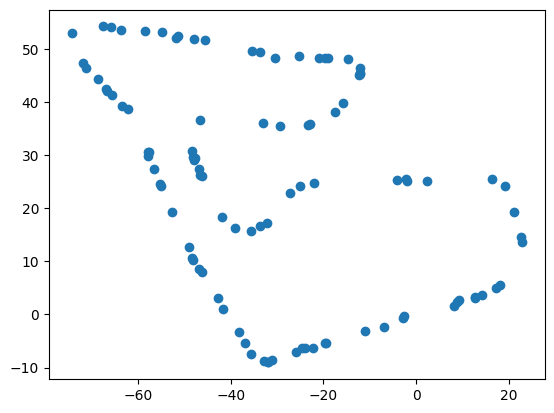

In [19]:
import matplotlib.pyplot as plt
plt.plot(env_states_all[0].cartesian_states[:, 0, 0], env_states_all[0].cartesian_states[:, 0, 1], 'o')